In [3]:
## LIBRERIAS
from google.colab import drive, files
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
from keras import Model, Sequential
from keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Rescaling, GlobalAveragePooling2D, RandomFlip, Input, RandomContrast
from keras.preprocessing.image import ImageDataGenerator
import random
import os
random.seed(1234)

In [ ]:
## Cargamos Drive e importamos las imágenes de train y test
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/Sentinel2LULC_354.zip" -d "/content"
!unzip "/content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/Sentinel2LULC_Test.zip" -d "/content"

In [ ]:
## Descargamos y descomprimimos los pesos "noisy student" más recientes
## de EfficientNetB1
!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/advprop/efficientnet-b1.tar.gz
!tar -xf efficientnet-b1.tar.gz -C /content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle

--2022-03-14 18:53:05--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/advprop/efficientnet-b1.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.140.128, 108.177.15.128, 173.194.76.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.140.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57868007 (55M) [application/gzip]
Saving to: ‘efficientnet-b1.tar.gz’

efficientnet-b1.tar 100%[===================>]  55.19M  50.2MB/s    in 1.1s    

2022-03-14 18:53:06 (50.2 MB/s) - ‘efficientnet-b1.tar.gz’ saved [57868007/57868007]



In [ ]:
## Convertimos los pesos a formato h5
!python /content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/efficientnet_weight_update_util.py --model b1 --notop --ckpt \
        /content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/efficientnet-b1/model.ckpt --o /content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/efficientnetb1_notop.h5

In [5]:
## Renombramos las carpetas para que tf las lea en orden
dirnames = sorted(os.listdir("Sentinel2LULC_354"))
for dir in dirnames:
  newname = ""

  if (len(dir.split('_')[0]) == 1):
    newname = '0'+dir.split('_')[0]
  else:
    newname = dir.split('_')[0]

  os.rename("Sentinel2LULC_354/"+dir,"Sentinel2LULC_354/"+newname)

In [6]:
## Leemos las imágenes de train, validacion y test

training = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_354",
  validation_split=0.2,
  subset="training",
  seed=1234,
  image_size=(224, 224),
  batch_size = 32)

validation = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_354",
  validation_split=0.2,
  subset="validation",
  seed=1234,
  image_size=(224, 224),
  batch_size = 32)

test = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_Test",
  shuffle=False,
  labels=None,
  image_size=(224, 224),
  batch_size = 32)


Found 10266 files belonging to 29 classes.
Using 8213 files for training.
Found 10266 files belonging to 29 classes.
Using 2053 files for validation.
Found 1618 files belonging to 1 classes.


2022/03/17 10:55:11 INFO mlflow.tracking.fluent: Experiment with name 'EfficientNetB1 con DataAugmentation (AdvProp)' does not exist. Creating a new experiment.


Epoch 1/25
257/257 [==============================] - 52s 129ms/step - loss: 2.3416 - accuracy: 0.5404 - val_loss: 1.2731 - val_accuracy: 0.6201
Epoch 2/25
257/257 [==============================] - 31s 120ms/step - loss: 1.4110 - accuracy: 0.6443 - val_loss: 1.1425 - val_accuracy: 0.6732
Epoch 3/25
257/257 [==============================] - 32s 122ms/step - loss: 1.1682 - accuracy: 0.6661 - val_loss: 1.0675 - val_accuracy: 0.6878
Epoch 4/25
257/257 [==============================] - 32s 124ms/step - loss: 1.0411 - accuracy: 0.6856 - val_loss: 0.9552 - val_accuracy: 0.6980
Epoch 5/25
257/257 [==============================] - 32s 123ms/step - loss: 0.9855 - accuracy: 0.6868 - val_loss: 0.9953 - val_accuracy: 0.6834
Epoch 6/25
257/257 [==============================] - 32s 122ms/step - loss: 0.9366 - accuracy: 0.7016 - val_loss: 0.9780 - val_accuracy: 0.6897
Epoch 7/25
257/257 [==============================] - 32s 123ms/step - loss: 0.9261 - accuracy: 0.7102 - val_loss: 0.9238 - val_ac

2022/03/17 11:02:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


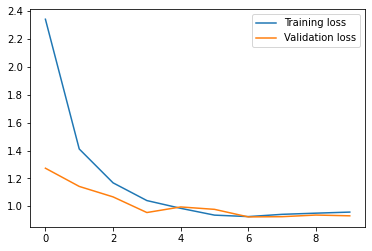

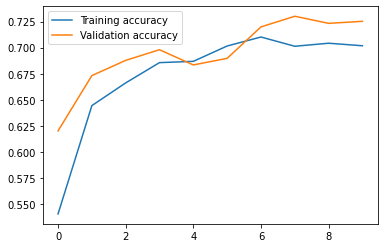

In [7]:
## Función que muestra la evolución de las accuracy de train y validacion
## durante el entrenamiento.
def mostrarEvolucion(hist):

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()

## Creamos el modelo con las capas de Data Augmentation.
## Solo RandomFlip parece ir bien. 
augmentation = Sequential([
        RandomFlip()
])

## Vamos a entrenar usando la red EfficietNetB1
base_model = tf.keras.applications.EfficientNetB1(include_top=False,
                                                  weights='/content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/efficientnetb1_notop.h5',
                                                  pooling='avg')

base_model.trainable = False

## Capa de entrada
entrada = Input(shape=(224,224,3))

## Capa de normalizacion
normalization = Rescaling(1./255)

## Capa de salida
prediction_layer = Dense(29, activation="softmax")

## Creamos nuestro modelo final juntando todos los submodelos/capas
## anteriores
model = Sequential([
  entrada,
  augmentation,
  base_model,
  BatchNormalization(),
  Dropout(0.2),
  prediction_layer
])

opt = Adam(learning_rate=1e-2)
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("EfficientNetB1 con DataAugmentation (AdvProp)")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                    epochs=25,
                    validation_data=validation,
                    callbacks=callback)

  mostrarEvolucion(history)

Epoch 1/10
257/257 [==============================] - 141s 496ms/step - loss: 1.3084 - accuracy: 0.6344 - val_loss: 0.6821 - val_accuracy: 0.7823
Epoch 2/10
257/257 [==============================] - 125s 484ms/step - loss: 0.6553 - accuracy: 0.7857 - val_loss: 0.4409 - val_accuracy: 0.8583
Epoch 3/10
257/257 [==============================] - 125s 485ms/step - loss: 0.5189 - accuracy: 0.8315 - val_loss: 0.4102 - val_accuracy: 0.8622
Epoch 4/10
257/257 [==============================] - 125s 484ms/step - loss: 0.4327 - accuracy: 0.8518 - val_loss: 0.3625 - val_accuracy: 0.8846
Epoch 5/10
257/257 [==============================] - 125s 485ms/step - loss: 0.3518 - accuracy: 0.8768 - val_loss: 0.3584 - val_accuracy: 0.8724
Epoch 6/10
257/257 [==============================] - 124s 482ms/step - loss: 0.3114 - accuracy: 0.8920 - val_loss: 0.3585 - val_accuracy: 0.8709
Epoch 7/10
257/257 [==============================] - 124s 483ms/step - loss: 0.3056 - accuracy: 0.8953 - val_loss: 0.3847 -

2022/03/17 11:21:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


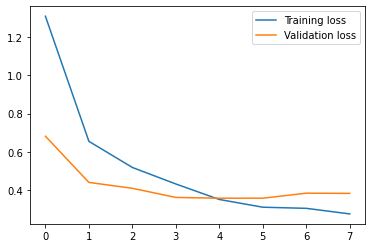

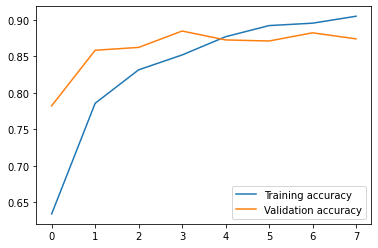

In [8]:
## FINE TUNING: Volvemos a entrenar descongelando algunas capas (menos las BatchNormalization)

def unfreeze_model(model):
    for layer in model.layers[-20:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

    opt = Adam(learning_rate=1e-4)
    model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])


unfreeze_model(model)

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                    epochs=10,
                    validation_data=validation,
                    callbacks=callback)

  mostrarEvolucion(history)

In [9]:
## Predecimos las clases
y_pred = model.predict(test)
classes = np.argmax(y_pred, axis=1)
classes = np.array(classes)
classes = classes + 1
print(classes)

[10 10 10 ...  9  9  9]


In [10]:
## Creamos el csv con los resultados
d = {'id.jpg': sorted(os.listdir("Sentinel2LULC_Test")), 'label': classes}
df = pd.DataFrame(data=d)
df.to_csv('EfficientNetB1_AdvProp.csv', index=False)
files.download('EfficientNetB1_AdvProp.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>